# EXPLORATION 5 : 나의 첫 번째 캐글 경진대회

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


✓ 학습 데이터에서 라벨 제거하기

In [4]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

✓ 학습 데이터와 테스트 데이터 합치기

모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐봅니다.

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 데이터 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

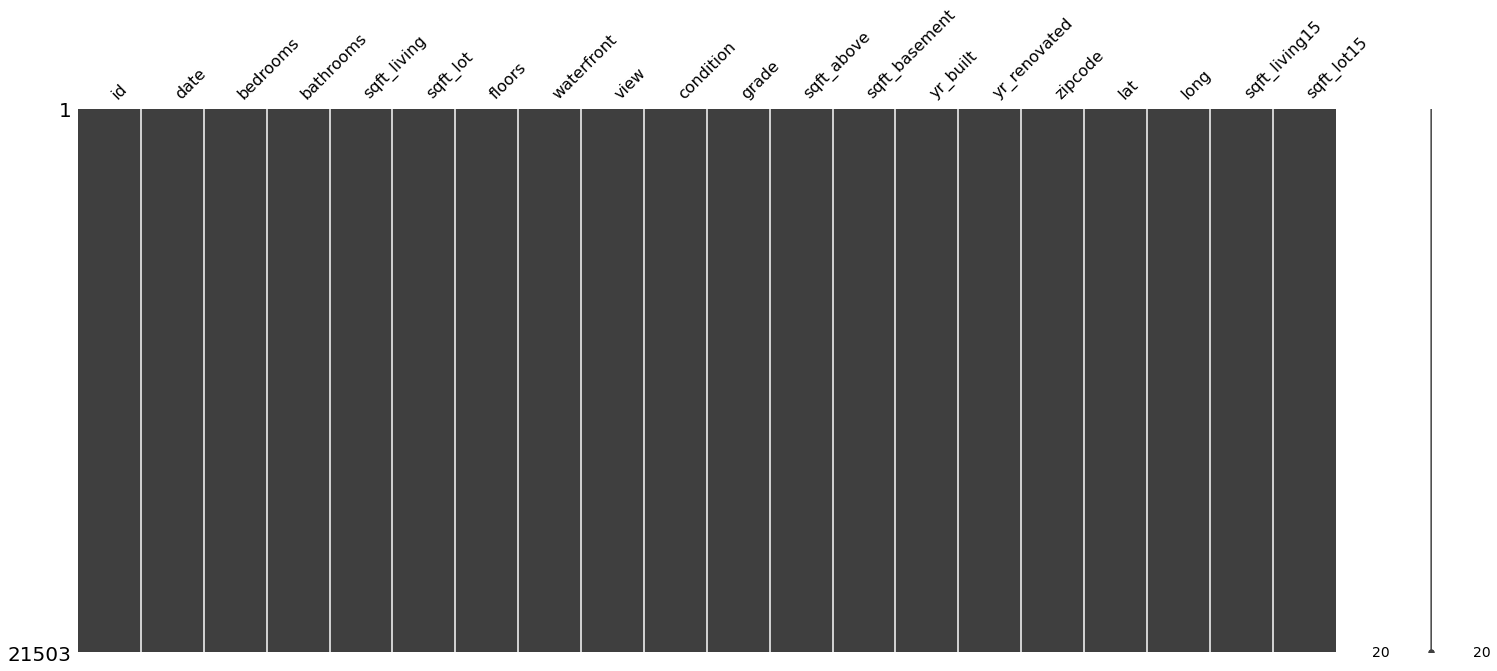

In [7]:
msno.matrix(data)

특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나오고, 결측치가 없다면 매트릭스 전체가 까맣게 나옴

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리

In [9]:
sub_id = data['id'][train_len:]
del data['id']

In [10]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

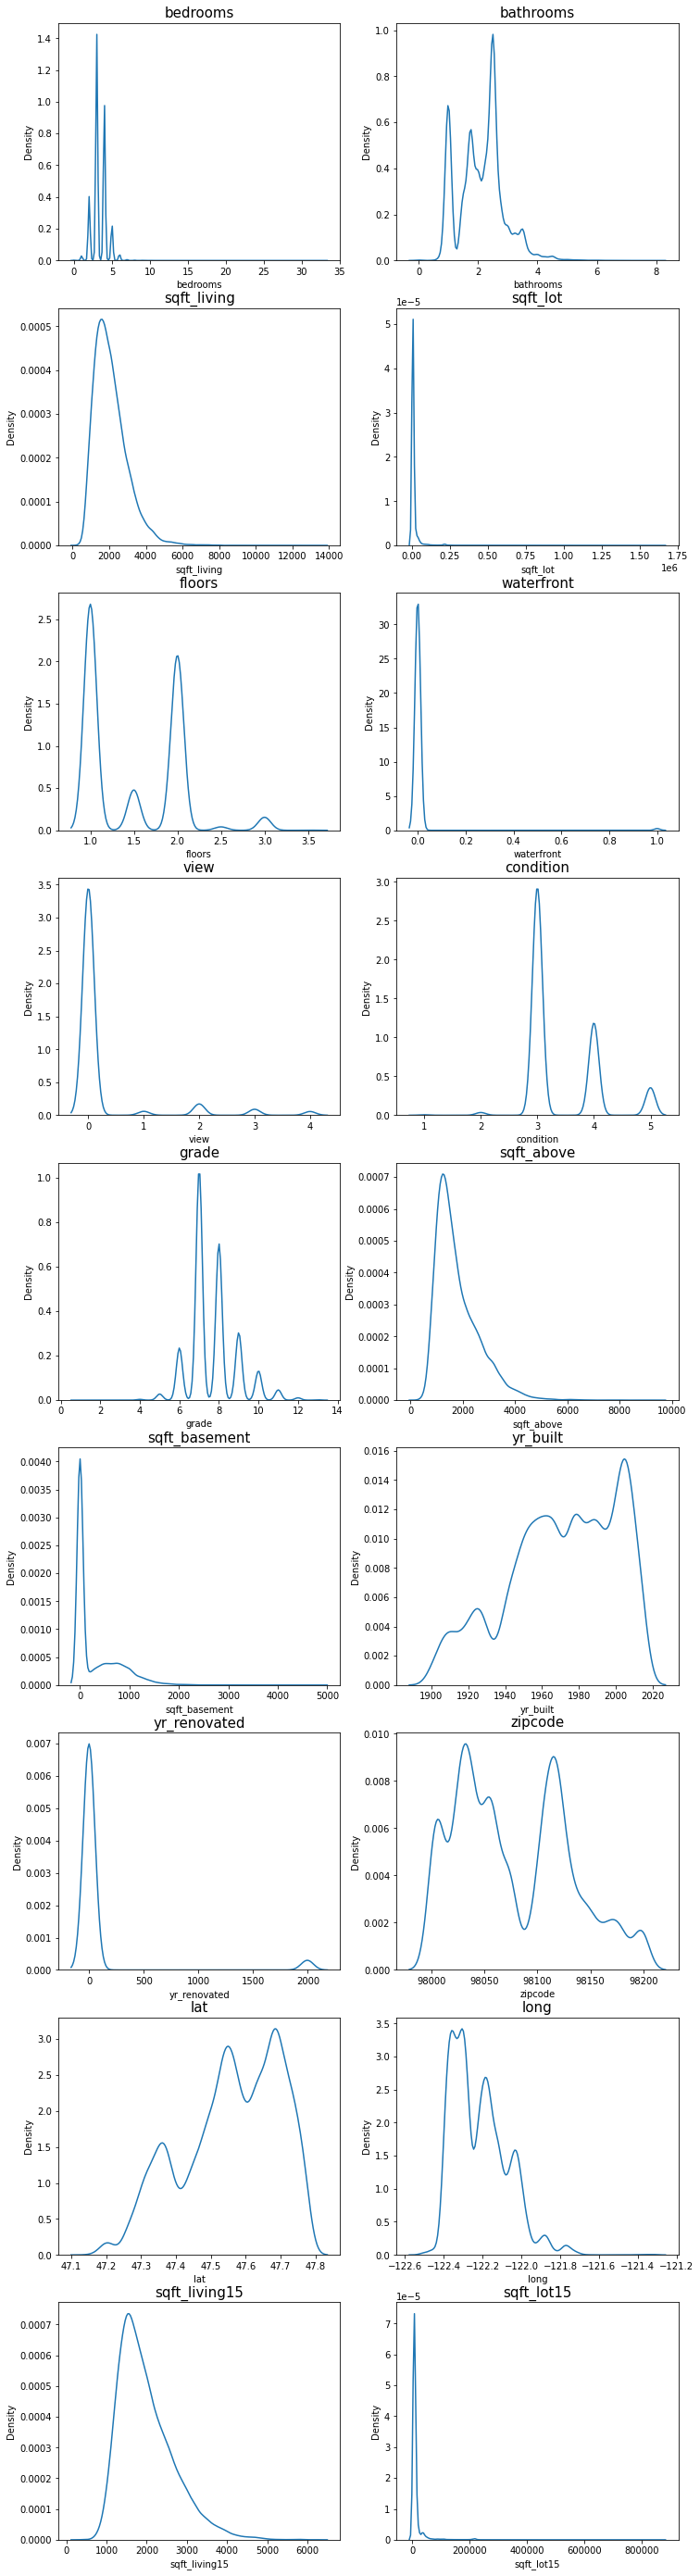

In [11]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [12]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

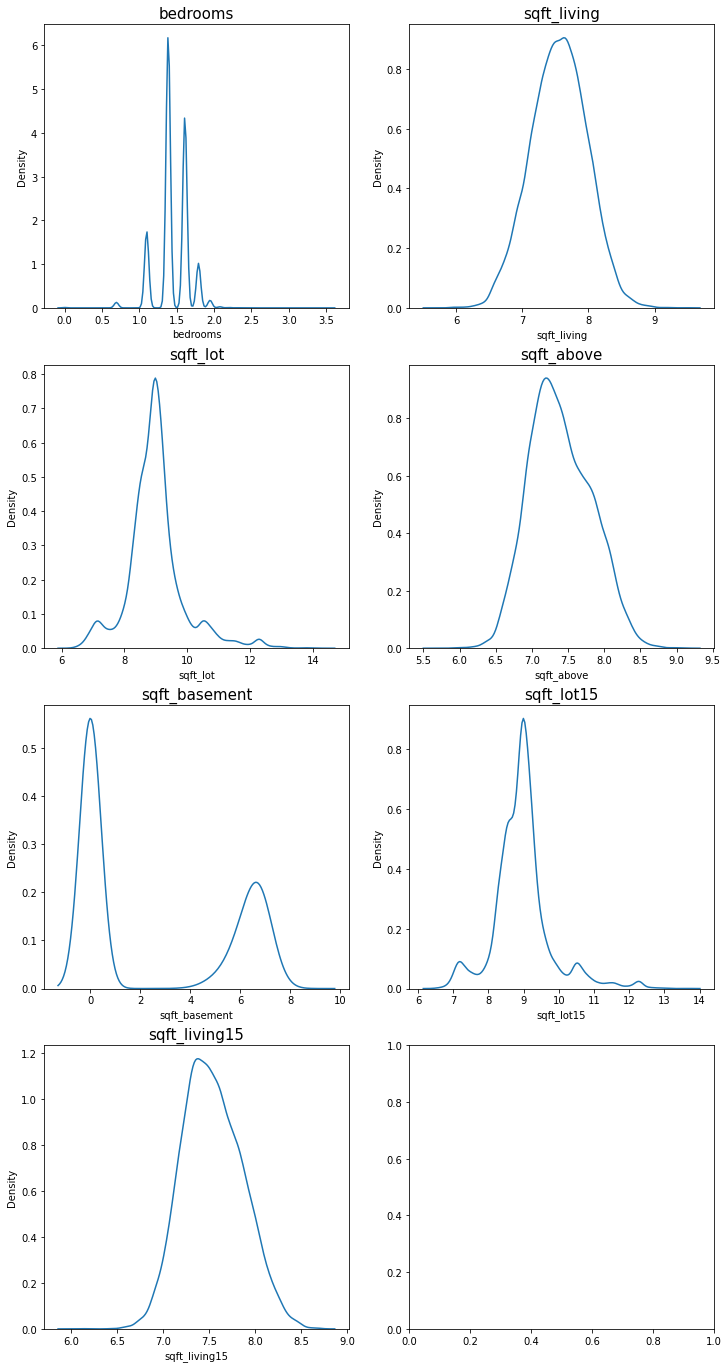

In [13]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

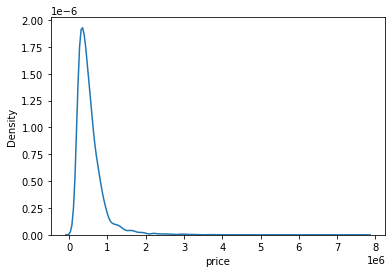

In [14]:
sns.kdeplot(y) #price도 로그변환
plt.show()

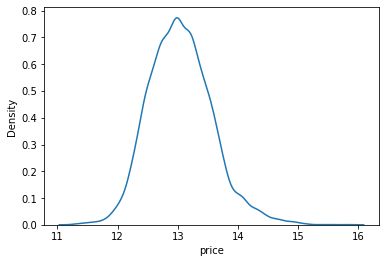

In [15]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [16]:
#위에서 저장한 train_len을 인덱스로 활용해서 학습 데이터와 테스트 데이터를 다시 나눈다.
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [17]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [18]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
        
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


GradientBoosting, CV score:0.8598
XGBoost, CV score:0.8860
LightGBM, CV score:0.8819
    
세가지 모델이 훈련 데이터에 대해 괜찮은 성능을 보여주고 있다.

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [19]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [20]:
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [21]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [22]:
result = pd.DataFrame({'id' : sub_id, 'price' : y_pred})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [23]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


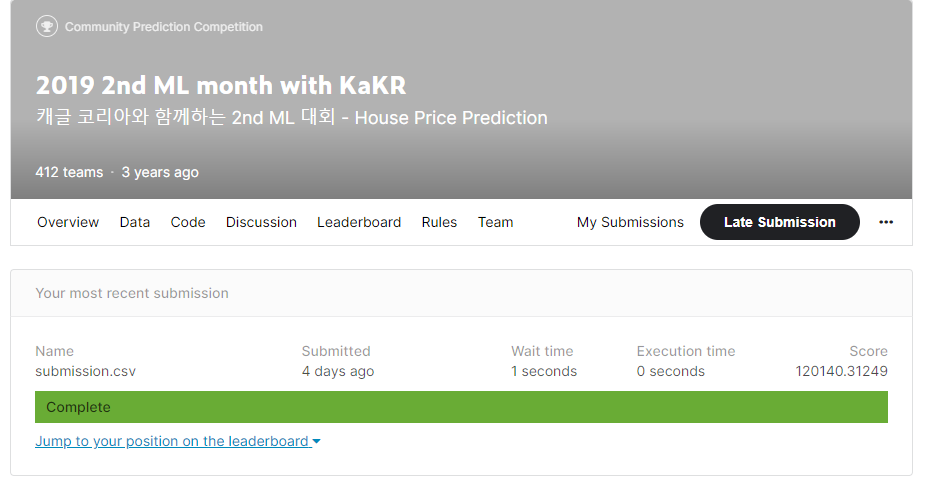

In [24]:
from IPython.display import Image
Image(os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/kk.PNG')

## 4. 데이터 튜닝 해보기

점수는 120000점 
110000이하의 점수를 얻어보자!

In [25]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price'] #y에 price 저장
del train['price'] #제거
del train['id']

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
del test['id']

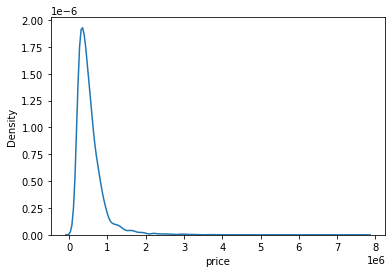

In [26]:
sns.kdeplot(y)
plt.show()

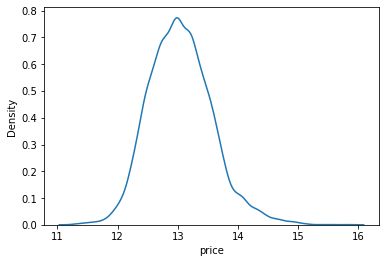

In [27]:
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

모델링
보다 다양하고 많은 실험을 하기 위해서는, 그만큼 실험을 위한 도구들이 잘 준비되어 있는것이 유리하다.

### RMSE

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

 #위에서 로그 변환을 했으므로 원래 데이터 단위에 맞게 돌려줌 np_expm
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

다음으로 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 가져오겠습니다.

In [30]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [31]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=11 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [32]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 127186.76581359295,
 'XGBRegressor': 106718.1055388896,
 'LGBMRegressor': 108190.52994526456,
 'RandomForestRegressor': 115312.65846727483}

In [33]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,127186.765814
RandomForestRegressor,115312.658467
LGBMRegressor,108190.529945
XGBRegressor,106718.105539


이제 다양한 하이퍼 파라미터로 실험하는 일이 남았죠

In [34]:
from sklearn.model_selection import GridSearchCV
import scipy.stats as stats
from sklearn.model_selection import RandomizedSearchCV

In [35]:
#my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)`

def my_RandomizedSearch(model, train, y, params, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    rand= RandomizedSearchCV(model, param_distributions=params, n_iter=15,
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    rand.fit(train, y)

    # 결과값 저장
    params = rand.cv_results_['params']
    score = rand.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('score')

    return results

In [36]:
params = {'n_estimators': stats.randint(50, 200),
          'max_depth': stats.randint(1, 15)}

model = LGBMRegressor(random_state=random_state)
my_RandomizedSearch(model, train, y, params, verbose=2, n_jobs=5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,max_depth,n_estimators,score,RMSE
14,1,115,0.810981,NaN
7,3,68,0.868954,NaN
3,3,145,0.887534,NaN
0,5,55,0.887558,NaN
12,3,155,0.888602,NaN
6,12,52,0.895590,NaN
1,12,61,0.897861,NaN
8,11,74,0.900562,NaN
10,6,136,0.902055,NaN
13,11,116,0.903329,NaN


In [37]:
model = LGBMRegressor(max_depth=2, n_estimators=150, random_state=random_state)

In [38]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [39]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.888')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.888.csv saved!


# 회고

캐글 점수를 얻는 것은 생각보다 너무 어려웠다.
다양한 시도를 해봤어야했는데 시간관계상 그러지 못했다.

먼저, 그리드 서치를 사용하여 최적의 (n_estimators, max_depth) 하이퍼 파라미터 값을 찾아야했다.
예시에 나온 조합을 참고하여 두개씩 (2*2)=4개의 조합 중 최적의 값을 찾아내었다.
캐글에 제출한 결과 11이 나왔다.

대안점으로 랜덤서치를 사용한다면 무작위로 더 좋은 결과를 내지 않을까 생각이 들었다.
랜덤서치는 범위안의 하이퍼 파라미터 값을 랜덤하게 넣어보고 그 중 우수한 값을 보인 하이퍼 파라미터를 활용해 모델을 생성한다. 그리드 서치는 사람이 임의로 정한값이기 때문에 우리가 지정한 모든 값을 탐색한다.
어떤 값이 효과적일지 알아보기로 했다.

랜덤 서치의 score와 RMSE 점수는 앞의 그리드 값과 다른 모습을 띄었다.
그리드서치의 score는 (-0.027, -0.056 ...)이었던 반면에 랜덤서치의 score는 0.9정도의 높은 값이 나왔다.
(분명 -값을 넣었지만 왜이런지 모르겠다.)

또한 그리드서치의 RMSE는 0.16~0.25 사이의 값이 나왔지만 랜덤서치의 RMSE는 NaN값이 나왔다.

이상했지만 가장 높은 결과를 캐글에 제출했다.
랜덤서치가 값을 더 잘 찾을 것이란 내 예상과는 달리 점수가 이전보다 더 못나왔다.
참담한 결과였다.

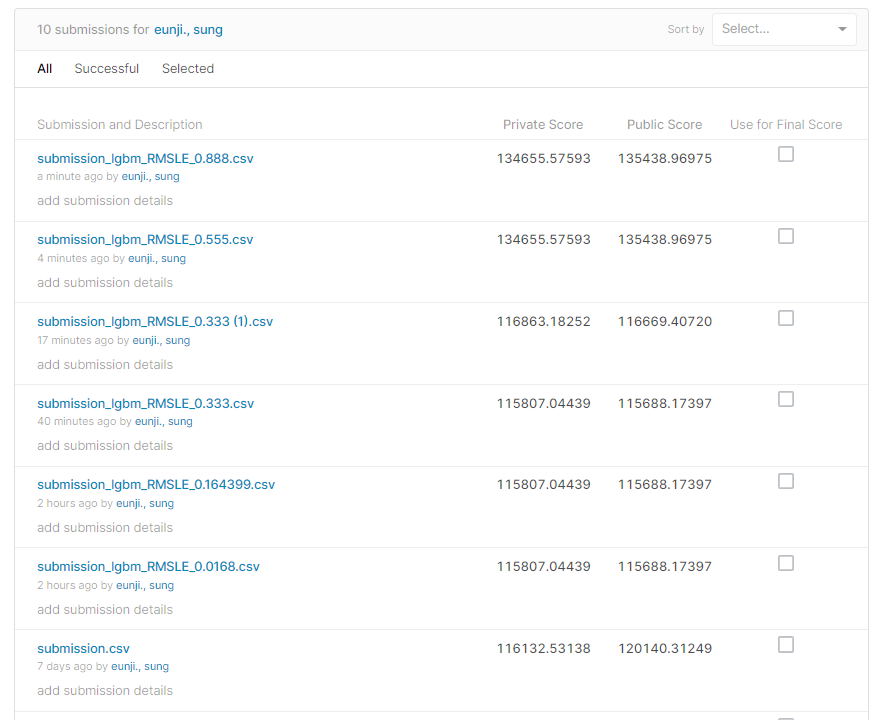

[CV] END .......................max_depth=5, n_estimators=55; total time=   0.3s
[CV] END ......................max_depth=12, n_estimators=61; total time=   0.4s
[CV] END ......................max_depth=12, n_estimators=61; total time=   0.4s
[CV] END .....................max_depth=13, n_estimators=187; total time=   0.9s
[CV] END .....................max_depth=13, n_estimators=187; total time=   1.6s
[CV] END .....................max_depth=10, n_estimators=197; total time=   1.7s
[CV] END ......................max_depth=12, n_estimators=52; total time=   0.4s
[CV] END ......................max_depth=11, n_estimators=74; total time=   0.5s
[CV] END .....................max_depth=14, n_estimators=179; total time=   0.9s
[CV] END ......................max_depth=6, n_estimators=136; total time=   0.6s
[CV] END ......................max_depth=6, n_estimators=136; total time=   0.6s
[CV] END ......................max_depth=9, n_estimators=183; total time=   1.0s
[CV] END ...................

In [40]:
Image(os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/kkall.PNG')